# Dimensionality Reduction

#### Importing libraries

In [1]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

#### Load Train and Test set

In [2]:
df_train_binary = pd.read_csv('csv/train_binary.csv')
df_test_binary = pd.read_csv('csv/test_binary.csv')

In [3]:
df_train_binary['Class'] = 0
df_test_binary['Class'] = 0

df_train_binary.loc[(df_train_binary['Activity']==2), 'Class'] = 1
df_test_binary.loc[(df_test_binary['Activity']==2), 'Class'] = 1

In [4]:
X_train = df_train_binary.drop(['subject','Activity','ActivityName','Class'], axis = 1)
y_train = df_train_binary.Class

In [5]:
X_test = df_test_binary.drop(['subject','Activity','ActivityName','Class'], axis = 1)
y_test = df_test_binary.Class

# Principal Component Analysis (PCA)

Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.

It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko, depending on the shape of the input data and the number of components to extract.

In [6]:
from sklearn.decomposition import PCA

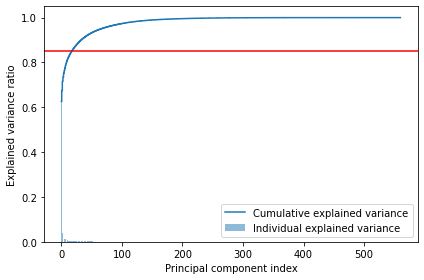

In [7]:
pca = PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.axhline(y=0.85, color='r', linestyle='-')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

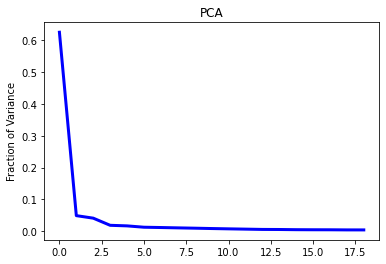

In [8]:
plt.plot(PCA(n_components=19).fit(X_train).explained_variance_ratio_, lw=3, color='b', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

In [9]:
pca = PCA(0.85)
pc = pca.fit_transform(X_train) # << to retain the components in an object
pc

#pca.explained_variance_ratio_
print ( "Components = ", pca.n_components_ , ";\nTotal explained variance = ",
      round(pca.explained_variance_ratio_.sum(),5)  )

Components =  19 ;
Total explained variance =  0.85374


In [10]:
pca = PCA(n_components=19)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)

In [11]:
X_train_pca.shape

(7352, 19)

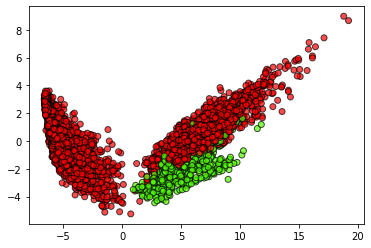

In [12]:
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=plt.cm.prism, edgecolor='k', alpha=0.7)
plt.show()

In [13]:
X_test_pca = pca.transform(X_test)

#### Decision tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, PrecisionRecallDisplay, plot_precision_recall_curve

In [15]:
# Decision tree UNBALANCED
clf_DT = DecisionTreeClassifier()
clf_DT.fit(X_train_pca, y_train)

DecisionTreeClassifier()

In [16]:
# Hyperparameter tuning: takes less 1 min
param_list = {"criterion": ['gini', 'entropy'], # impurity measurement 
              'max_depth': [None] + [2, 3, 4, 6, 8, 10], # cut of the leaf
             'min_samples_split': [2, 3, 4, 5, 8, 10], # min n. of samples required in a node to split the node
             'min_samples_leaf': [1, 2, 3, 4, 5, 10] # min n. of samples required to be in both left and right 
                                                                         # child of a parent node to split that parent node
             }
random_search = RandomizedSearchCV(clf_DT, param_distributions=param_list, scoring='recall', n_iter=50, random_state=42)
random_search.fit(X_train_pca, y_train)

res = random_search.cv_results_

In [17]:
random_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5)

In [18]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [19]:
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.805 (std: 0.120)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.793 (std: 0.145)
Parameters: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.793 (std: 0.147)
Parameters: {'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 10, 'criterion': 'entropy'}



In [20]:
clf_DT = DecisionTreeClassifier(criterion='entropy', max_depth=6, min_samples_leaf=5, min_samples_split= 2)
clf_DT.fit(X_train_pca, y_train)

y_pred = clf_DT.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9606379368849678
F1-score [0.97665996 0.87445887]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2476
           1       0.89      0.86      0.87       471

    accuracy                           0.96      2947
   macro avg       0.93      0.92      0.93      2947
weighted avg       0.96      0.96      0.96      2947



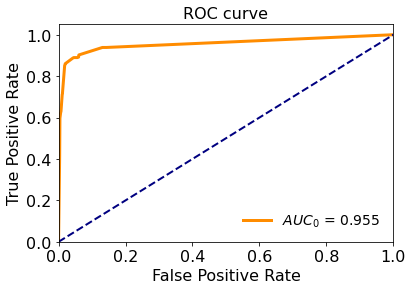

In [21]:
y_score = clf_DT.predict_proba(X_test_pca)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [23]:
prc_auc = auc(recall, precision)
prc_auc

0.9051274230566466

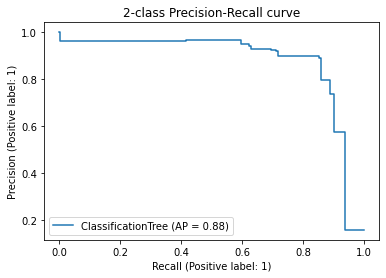

In [24]:
y_score = clf_DT.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [25]:
# Decision tree + IMBALANCE LEARNING

## Undersampling

from imblearn.under_sampling import RandomUnderSampler

In [26]:
### RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)
X_res, y_res = rus.fit_resample(X_train_pca, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1073, 1: 1073})


In [27]:
clf_DT_rus = DecisionTreeClassifier()
clf_DT_rus.fit(X_res, y_res)

DecisionTreeClassifier()

In [28]:
# Hyperparameter tuning: takes less 1 min
param_list = {"criterion": ['gini', 'entropy'], # impurity measurement 
              'max_depth': [None] + [2, 3, 4, 6, 8, 10], # cut of the leaf
             'min_samples_split': [2, 3, 4, 5, 8, 10], # min n. of samples required in a node to split the node
             'min_samples_leaf': [1, 2, 3, 4, 5, 10] # min n. of samples required to be in both left and right 
                                                                         # child of a parent node to split that parent node
             }
random_search = RandomizedSearchCV(clf_DT_rus, param_distributions=param_list, scoring='recall', n_iter=50, random_state=42)
random_search.fit(X_res, y_res)

res = random_search.cv_results_

In [29]:
random_search.best_estimator_

DecisionTreeClassifier(max_depth=2, min_samples_leaf=10, min_samples_split=4)

In [30]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [31]:
report(res, n_top=3)

Model with rank: 1
Mean validation score: 0.895 (std: 0.076)
Parameters: {'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'gini'}

Model with rank: 1
Mean validation score: 0.895 (std: 0.076)
Parameters: {'min_samples_split': 8, 'min_samples_leaf': 10, 'max_depth': 2, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.888 (std: 0.101)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 6, 'criterion': 'entropy'}



In [32]:
clf_DT_rus = DecisionTreeClassifier(criterion='gini', max_depth=2, min_samples_leaf=10, min_samples_split= 4)
clf_DT_rus.fit(X_res, y_res)

y_pred = clf_DT_rus.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8747879199185612
F1-score [0.92004334 0.71149335]
              precision    recall  f1-score   support

           0       0.99      0.86      0.92      2476
           1       0.56      0.97      0.71       471

    accuracy                           0.87      2947
   macro avg       0.78      0.91      0.82      2947
weighted avg       0.92      0.87      0.89      2947



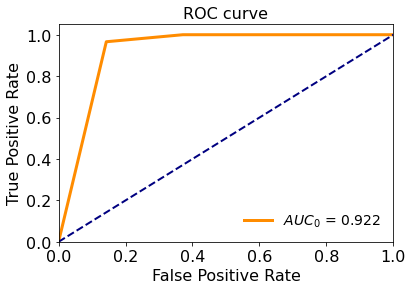

In [33]:
y_score = clf_DT_rus.predict_proba(X_test_pca)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [34]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [35]:
prc_auc = auc(recall, precision)
prc_auc

0.770329663619801

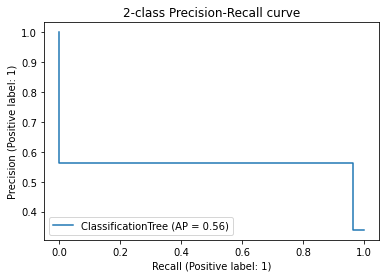

In [36]:
y_score = clf_DT_rus.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [37]:
## Oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [38]:
### RandomOverSampler
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_pca, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6279, 1: 6279})


In [39]:
clf_DT_ros = DecisionTreeClassifier()
clf_DT_ros.fit(X_res, y_res)

DecisionTreeClassifier()

In [40]:
# Hyperparameter tuning: takes 1 min
param_list = {"criterion": ['gini', 'entropy'], # impurity measurement 
              'max_depth': [None] + [2, 3, 4, 6, 8, 10], # cut of the leaf
             'min_samples_split': [2, 3, 4, 5, 8, 10], # min n. of samples required in a node to split the node
             'min_samples_leaf': [1, 2, 3, 4, 5, 10] # min n. of samples required to be in both left and right 
                                                                         # child of a parent node to split that parent node
             }
random_search = RandomizedSearchCV(clf_DT_ros, param_distributions=param_list, scoring='recall', n_iter=50, random_state=42)
random_search.fit(X_res, y_res)

res = random_search.cv_results_

In [41]:
random_search.best_estimator_

DecisionTreeClassifier()

In [42]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [43]:
report(res, n_top=3)

Model with rank: 1
Mean validation score: 1.000 (std: 0.000)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}

Model with rank: 2
Mean validation score: 1.000 (std: 0.001)
Parameters: {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}

Model with rank: 3
Mean validation score: 0.999 (std: 0.001)
Parameters: {'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'gini'}



In [44]:
clf_DT_ros = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_leaf=1, min_samples_split= 4)
clf_DT_ros.fit(X_res, y_res)

y_pred = clf_DT_ros.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9433322022395657
F1-score [0.96633743 0.8210075 ]
              precision    recall  f1-score   support

           0       0.96      0.97      0.97      2476
           1       0.83      0.81      0.82       471

    accuracy                           0.94      2947
   macro avg       0.90      0.89      0.89      2947
weighted avg       0.94      0.94      0.94      2947



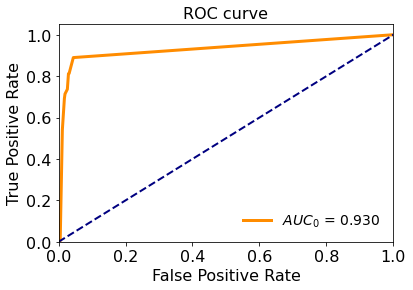

In [45]:
y_score = clf_DT_ros.predict_proba(X_test_pca)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [46]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [47]:
prc_auc = auc(recall, precision)
prc_auc

0.6350120378492126

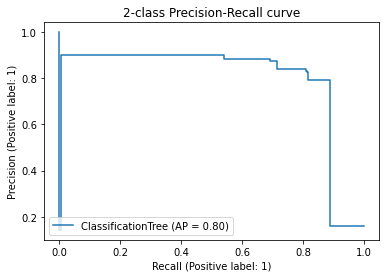

In [48]:
y_score = clf_DT_ros.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [49]:
### SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_pca, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6279, 1: 6279})


In [50]:
clf_DT_sm = DecisionTreeClassifier()
clf_DT_sm.fit(X_res, y_res)

DecisionTreeClassifier()

In [51]:
# Hyperparameter tuning: takes 1 min
param_list = {"criterion": ['gini', 'entropy'], # impurity measurement 
              'max_depth': [None] + [2, 3, 4, 6, 8, 10], # cut of the leaf
             'min_samples_split': [2, 3, 4, 5, 8, 10], # min n. of samples required in a node to split the node
             'min_samples_leaf': [1, 2, 3, 4, 5, 10] # min n. of samples required to be in both left and right 
                                                                         # child of a parent node to split that parent node
             }
random_search = RandomizedSearchCV(clf_DT_sm, param_distributions=param_list, scoring='recall', n_iter=50, random_state=42)
random_search.fit(X_res, y_res)

res = random_search.cv_results_

In [52]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
report(res,n_top=3)

Model with rank: 1
Mean validation score: 0.991 (std: 0.005)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}

Model with rank: 2
Mean validation score: 0.991 (std: 0.005)
Parameters: {'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 10, 'criterion': 'entropy'}

Model with rank: 3
Mean validation score: 0.988 (std: 0.007)
Parameters: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'gini'}



In [53]:
clf_DT_sm = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=1, min_samples_split= 2)
clf_DT_sm.fit(X_res, y_res)

y_pred = clf_DT_sm.predict(X_test_pca)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9497794367153037
F1-score [0.97006472 0.84421053]
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      2476
           1       0.84      0.85      0.84       471

    accuracy                           0.95      2947
   macro avg       0.90      0.91      0.91      2947
weighted avg       0.95      0.95      0.95      2947



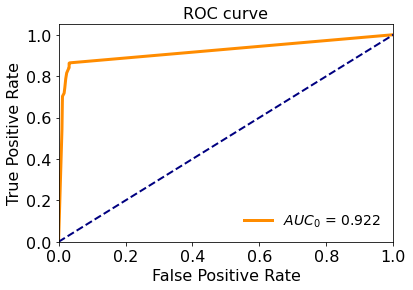

In [54]:
y_score = clf_DT_sm.predict_proba(X_test_pca)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [55]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [56]:
prc_auc = auc(recall, precision)
prc_auc

0.872905353653985

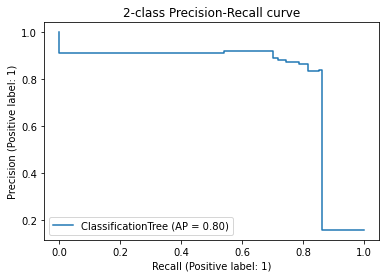

In [57]:
y_score = clf_DT_sm.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

#### kNN

In [58]:
from sklearn.neighbors import KNeighborsClassifier

In [59]:
# knn UNBALANCED (takes 5 min)

parameters = {'n_neighbors': np.arange(20, 100 + 1), 'weights':['uniform', 'distance']}

clf_knn = KNeighborsClassifier()
search = GridSearchCV(clf_knn, parameters)
search.fit(X_train_pca, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100]),
                         'weights': ['uniform', 'distance']})

In [60]:
search.best_estimator_

KNeighborsClassifier(n_neighbors=52, weights='distance')

In [61]:
clf_knn = KNeighborsClassifier(n_neighbors=52, weights='distance')
clf_knn.fit(X_train_pca, y_train)

KNeighborsClassifier(n_neighbors=52, weights='distance')

In [62]:
y_pred = clf_knn.predict(X_test_pca)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9664065151001018
F1-score [0.98007647 0.89297297]
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2476
           1       0.91      0.88      0.89       471

    accuracy                           0.97      2947
   macro avg       0.94      0.93      0.94      2947
weighted avg       0.97      0.97      0.97      2947



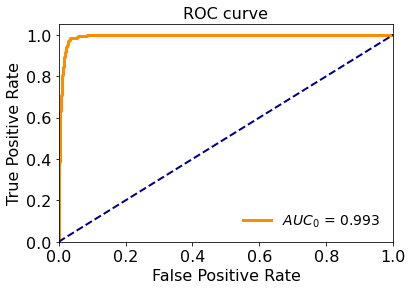

In [63]:
y_score = clf_knn.predict_proba(X_test_pca)

fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [64]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [65]:
prc_auc = auc(recall, precision)
prc_auc

0.9560192100334516

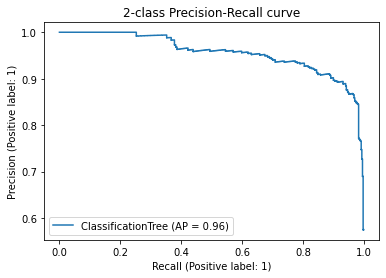

In [66]:
y_score = clf_knn.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [67]:
# knn + IMBALANCE LEARNING

## Undersampling

from imblearn.under_sampling import RandomUnderSampler

In [68]:
### RandomUnderSampler (takes 1 min)
rus = RandomUnderSampler(random_state = 42)
X_res, y_res = rus.fit_resample(X_train_pca, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 1073, 1: 1073})


In [69]:
clf_knn_rus = KNeighborsClassifier()
clf_knn_rus.fit(X_res, y_res)

KNeighborsClassifier()

In [70]:
parameters = {'n_neighbors': np.arange(20, 100 + 1), 'weights':['uniform', 'distance']}

search = GridSearchCV(clf_knn_rus, parameters)
search.fit(X_res, y_res)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100]),
                         'weights': ['uniform', 'distance']})

In [71]:
search.best_estimator_

KNeighborsClassifier(n_neighbors=22, weights='distance')

In [72]:
clf_knn_rus = KNeighborsClassifier(n_neighbors=22, weights='distance')
clf_knn_rus.fit(X_res, y_res)
y_pred = clf_knn_rus.predict(X_test_pca)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9379029521547336
F1-score [0.96164326 0.83704363]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      2476
           1       0.72      1.00      0.84       471

    accuracy                           0.94      2947
   macro avg       0.86      0.96      0.90      2947
weighted avg       0.96      0.94      0.94      2947



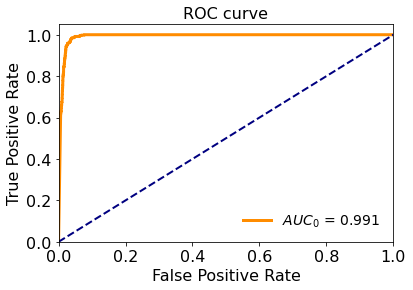

In [73]:
y_score = clf_knn_rus.predict_proba(X_test_pca)

fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [74]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [75]:
prc_auc = auc(recall, precision)
prc_auc

0.9474611347962053

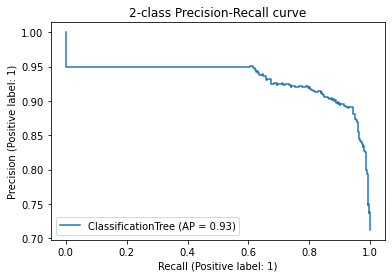

In [76]:
y_score = clf_knn_rus.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [77]:
## Oversampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [78]:
### RandomOverSampler (14 min)
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_pca, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6279, 1: 6279})


In [79]:
clf_knn_ros = KNeighborsClassifier()
clf_knn_ros.fit(X_res, y_res)

KNeighborsClassifier()

In [80]:
parameters = {'n_neighbors': np.arange(20, 100 + 1), 'weights':['uniform', 'distance']}

search = GridSearchCV(clf_knn_ros, parameters)
search.fit(X_res, y_res)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100]),
                         'weights': ['uniform', 'distance']})

In [81]:
search.best_estimator_

KNeighborsClassifier(n_neighbors=22)

In [82]:
clf_knn_ros = KNeighborsClassifier(n_neighbors=22, weights='uniform')
clf_knn_ros.fit(X_res, y_res)
y_pred = clf_knn_ros.predict(X_test_pca)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9518154054971157
F1-score [0.97060041 0.86654135]
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      2476
           1       0.78      0.98      0.87       471

    accuracy                           0.95      2947
   macro avg       0.89      0.96      0.92      2947
weighted avg       0.96      0.95      0.95      2947



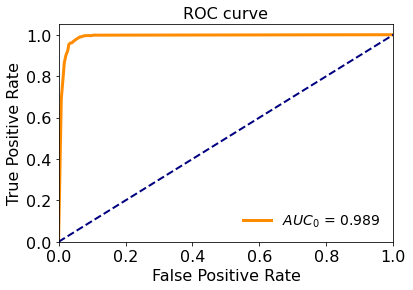

In [83]:
y_score = clf_knn_ros.predict_proba(X_test_pca)

fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [84]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [85]:
prc_auc = auc(recall, precision)
prc_auc

0.9446414979801661

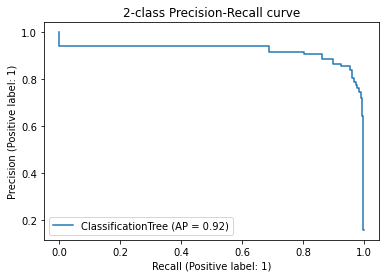

In [86]:
y_score = clf_knn_ros.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [87]:
### SMOTE (takes 12 min)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train_pca, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 6279, 1: 6279})


In [88]:
clf_knn_sm = KNeighborsClassifier()
clf_knn_sm.fit(X_res, y_res)

KNeighborsClassifier()

In [89]:
parameters = {'n_neighbors': np.arange(20, 100 + 1), 'weights':['uniform', 'distance']}

search = GridSearchCV(clf_knn_sm, parameters)
search.fit(X_res, y_res)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100]),
                         'weights': ['uniform', 'distance']})

In [90]:
search.best_estimator_

KNeighborsClassifier(n_neighbors=20)

In [91]:
clf_knn_sm = KNeighborsClassifier(n_neighbors=20, weights='uniform')
clf_knn_sm.fit(X_res, y_res)
y_pred = clf_knn_sm.predict(X_test_pca)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9467254835425857
F1-score [0.9674071 0.8542247]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97      2476
           1       0.76      0.98      0.85       471

    accuracy                           0.95      2947
   macro avg       0.88      0.96      0.91      2947
weighted avg       0.96      0.95      0.95      2947



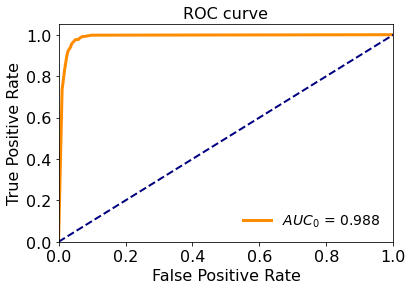

In [92]:
y_score = clf_knn_sm.predict_proba(X_test_pca)

fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [93]:
precision, recall, thresholds = precision_recall_curve(y_test, y_score[:,1])

In [94]:
prc_auc = auc(recall, precision)
prc_auc

0.9384966458679092

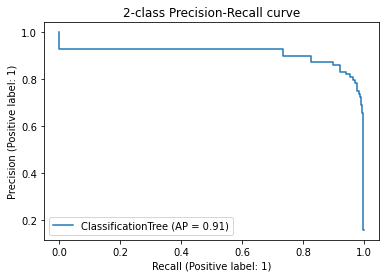

In [95]:
y_score = clf_knn_sm.predict_proba(X_test_pca)

display = PrecisionRecallDisplay.from_predictions(y_test, y_score[:,1], name="ClassificationTree")
_ = display.ax_.set_title("2-class Precision-Recall curve")

#### LOF

In [16]:
from sklearn.neighbors import LocalOutlierFactor

In [17]:
clf_LOF = LocalOutlierFactor(contamination=0.01, n_neighbors = 20) # n_neighbors = 20 is optimal value according to sklearn
outliers = clf_LOF.fit_predict(X_train_pca)

In [18]:
clf_LOF.negative_outlier_factor_

array([-1.47970133, -1.05256548, -1.01650728, ..., -1.09227059,
       -1.06266587, -0.99904301])

In [19]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  74, 7278], dtype=int64))

In [20]:
np.where(outliers==-1)

(array([   0,   31,   70,   71,   75,  176,  237,  238,  246,  388,  389,
         450,  564,  870,  872,  883, 1040, 1062, 1194, 1208, 1209, 1216,
        1343, 1397, 1425, 1426, 1523, 1813, 1817, 1904, 2111, 2112, 2440,
        2451, 2525, 2531, 2532, 2744, 2786, 2911, 2912, 2937, 3238, 3274,
        3477, 3900, 3934, 3935, 4222, 4281, 4284, 4404, 4565, 4580, 4604,
        4729, 4730, 4748, 4755, 4774, 4775, 4776, 4828, 5066, 5108, 5137,
        5147, 5535, 5899, 6332, 6335, 6519, 6910, 7189], dtype=int64),)

In [21]:
clf_LOF.negative_outlier_factor_[np.where(outliers==-1)]

array([-1.47970133, -1.30660718, -1.93747348, -1.88516122, -1.29508328,
       -1.28985488, -1.31221574, -1.42717864, -1.35480993, -1.45641824,
       -1.39202411, -1.30913465, -1.43664626, -1.34792133, -1.42492768,
       -1.35617504, -1.31843122, -1.36178849, -1.38938079, -1.43000718,
       -1.59352118, -1.30128821, -1.39725264, -1.31406344, -1.42658281,
       -1.29006934, -1.57000642, -1.35883203, -1.38823202, -1.71937911,
       -1.29150875, -1.43010424, -1.37345797, -1.65365422, -1.29829839,
       -1.60146477, -1.76513896, -1.32352292, -1.28957007, -1.31859223,
       -1.29608636, -1.41795158, -1.31389361, -1.31026978, -1.29185146,
       -1.28880263, -1.54344149, -1.51145467, -1.30975634, -1.37649921,
       -1.32264864, -1.29788862, -1.38387402, -1.59833402, -1.32014012,
       -1.3725585 , -1.5129925 , -1.38675942, -1.2922498 , -1.29039915,
       -1.33929787, -1.29640704, -1.29488393, -1.87206123, -1.30179455,
       -1.36845035, -1.42849151, -1.30320689, -1.30611248, -1.41

In [22]:
max_val = np.max(clf_LOF.negative_outlier_factor_[np.where(outliers==-1)])
max_val

-1.2888026264699708

In [23]:
min_val = np.min(clf_LOF.negative_outlier_factor_[np.where(outliers==-1)])
min_val

-1.9374734788700247

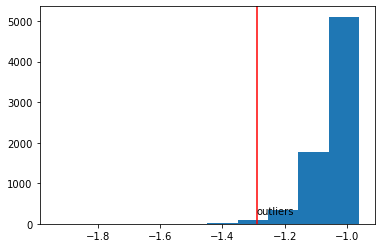

In [24]:
plt.hist(clf_LOF.negative_outlier_factor_, bins=10)
plt.axvline(max_val, c='r')
plt.text(max_val, 250, 'outliers')
plt.show()

#### Isolation Forest

In [25]:
from sklearn.ensemble import IsolationForest

In [26]:
clf_ISOFOR = IsolationForest(contamination=0.01, random_state=0)
clf_ISOFOR.fit(X_train_pca)

IsolationForest(contamination=0.01, random_state=0)

In [27]:
outliers = clf_ISOFOR.predict(X_test_pca)

In [28]:
np.unique(outliers, return_counts=True)

(array([-1,  1]), array([  12, 2935], dtype=int64))

In [29]:
np.where(outliers==-1)

(array([ 273,  525, 1484, 1485, 1486, 2457, 2497, 2508, 2528, 2529, 2530,
        2536], dtype=int64),)